In [1]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform
import numpy.random as npr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
%matplotlib inline

## Importation Data & Plot

In [2]:
z = open( 'ZoneA.dat','r' ).readlines()
z = [ i.strip().split() for i in z[10:] ]
z = np.array( z, dtype=np.float )
z = DataFrame( z, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )
z

C:\Users\vince\AppData\Local\Temp\ipykernel_10520\921040611.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )


,x,y,thk,por,perm,lperm,lpermp,lpermr
0,12100.0,8300.0,37.1531,14.6515,2.8547,0.4556,0.1357,0.3198
1,5300.0,8700.0,31.4993,14.5093,-999.9999,-999.9999,-999.9999,-999.9999
2,3500.0,13900.0,36.9185,14.0639,-999.9999,-999.9999,-999.9999,-999.9999
3,5100.0,1900.0,24.0156,15.1084,1.1407,0.0572,0.2268,-0.1696
4,9900.0,13700.0,35.0411,13.9190,-999.9999,-999.9999,-999.9999,-999.9999
...,...,...,...,...,...,...,...,...
80,3500.0,7500.0,33.2246,15.1486,1.4744,0.1686,0.2348,-0.0662
81,3700.0,6900.0,30.6871,13.9584,-999.9999,-999.9999,-999.9999,-999.9999
82,14500.0,13300.0,39.6297,14.7381,2.9050,0.4631,0.1530,0.3102
83,4900.0,9100.0,31.2961,15.0689,-999.9999,-999.9999,-999.9999,-999.9999


Text(0, 0.5, 'Y')

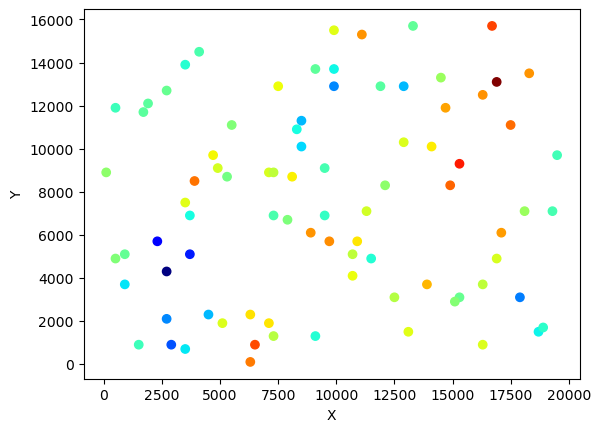

In [3]:
fig, ax = subplots()
ax.scatter( z.x, z.y, c=z.por,cmap='jet' )
xlabel('X')
ylabel('Y')

## fonction Variogram

In [4]:
def SVh( P, h, bw ): #### Variogram pour un lag particulier
    pd = squareform( pdist( P[:,:2] ) ) ## distances entre points
    N = pd.shape[0] ## N = 85
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ): ## si on est entre les bornes de distances
                Z.append( ( P[i,2] - P[j,2] )**2.0 ) ## (Z_{i}-Z{j})²
    return np.sum( Z ) / ( 2.0 * len( Z ) )

In [5]:
def SV( P, hs, bw ):### Variogram pour ensemble des lags
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )  ### calcul du variogram pour un lag
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ] ## sv[0]:[0,500,...,10000];sv[1]:[semivariogram]
    return np.array( sv ).T

## Calcul Semi-Variogram

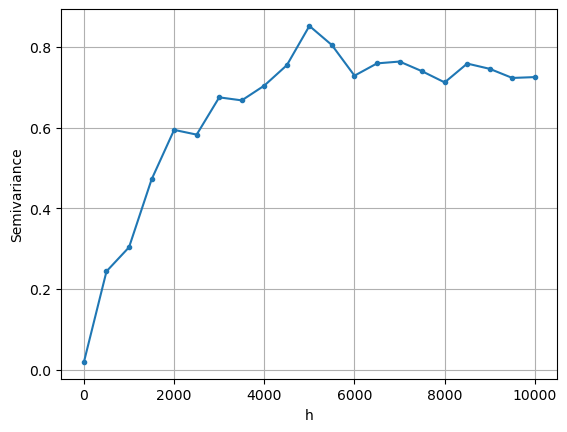

In [6]:
# part of our data set recording porosity
P = np.array( z[['x','y','por']] )
# bandwidth, plus or minus 250 meters
bw = 500
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,10500,bw)
sv = SV( P, hs, bw )
plot( sv[0], sv[1], '.-' )
xlabel('h')
ylabel('Semivariance')
plt.grid()

## Création du Modèle

In [8]:
def C( P, h, bw ): ## calcul du pallier
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

In [9]:
def opt( fct, x, y, c, parameterRange=None, meshSize=1000 ): ### optimisation des hyperparamètres du modèle
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], c ) )**2.0 )
    return a[ mse.argmin() ]

In [10]:
def typetest( h, a, lta, gta ):
    try:
        lt = lta( h[ np.where( h <= a ) ] )
        gt = gta( h[ np.where( h > a ) ] )
        return np.hstack((lt,gt))
    except TypeError:
        if h <= a:
            return lta( h )
        else:
            return gta( h )

In [11]:
def spherical( h, a, c ):
    a, c = float(a), float(c)
    lta = lambda x: c*( 1.5*(x/a) - 0.5*(x/a)**3.0 )
    gta = lambda x: c+x*0
    return typetest( h, a, lta, gta )

In [12]:
def exponential( h, a, c ):
    a, c = float( a ), float( c )
    return c*( 1.0 - np.exp( -3.0*h/a ) )


In [13]:
def gaussian( h, a, c ):
    a, c = float( a ), float( c )
    return c*( 1.0 - np.exp( -3.0*h**2.0/a**2.0 ) )

In [14]:
def cvmodel( P, model, hs, bw ):
    sv = SV( P, hs, bw ) ## calcul du semivariogram
    C0 = C( P, hs[0], bw ) ## calcul du pallier
    param = opt( model, sv[0], sv[1], C0 ) ## optimisation du paramètre du modèle
    covfct = lambda h, a=param: model( h, a, C0 ) ## retourne la fonction de covariance du modèle optimiser
    return covfct,C0

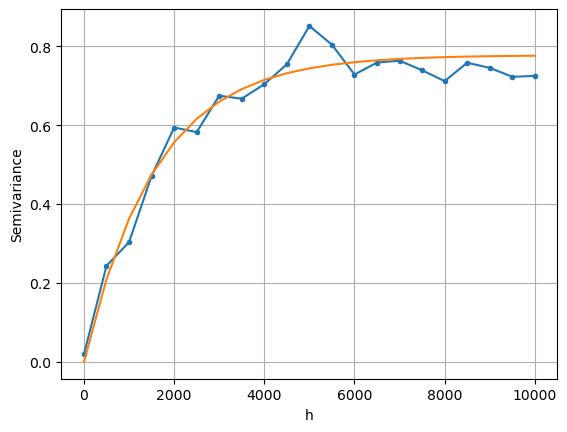

In [39]:
sp,pallier = cvmodel( P, model=exponential, hs=np.arange(0,10500,500), bw=500 )
plot( sv[0], sv[1], '.-' )
plot( sv[0], sp( sv[0] ) ) ;  
ylabel('Semivariance')
xlabel('h')
plt.grid()

## Simple Kriging

In [16]:
def krige( P, model, hs, bw, u, N ):
 
    covfct ,C0= cvmodel( P, model, hs, bw ) ##fonction de covariance
    mu = np.mean( P[:,2] ) ## moyenne des valeurs de toutes les données
 
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 ) ## matrice des distances entre le new et les points connus
    P = np.vstack(( P.T, d )).T ##ajout colonne distance
    P = P[d.argsort()[:N]]  ## garde les N premiers points proche de new
 
    k = covfct( P[:,3] ) 
    k = np.matrix( k ).T ## matrice des covariances entre le new et les N points
 
    K = squareform( pdist( P[:,:2] ) )
    K = covfct( K.ravel() )
    K = np.array( K )
    K = K.reshape(N,N)
    K = np.matrix( K ) ### matrice covariances entre les N points

    weights = np.linalg.inv( K ) * k
    weights = np.array( weights ) ## calcul des poids
 
    residuals = P[:,2] - mu ## calcul des résidus
 
    estimation = np.dot( weights.T, residuals ) + mu ##estimations de la valeurs à l'emplacement new
    return float( estimation )

## Application 

In [17]:
X0, X1 = P[:,0].min(), P[:,0].max()
Y0, Y1 = P[:,1].min(), P[:,1].max()
Z = np.zeros((80,100))
dx, dy = (X1-X0)/100.0, (Y1-Y0)/80.0
for i in range( 80 ):
    for j in range( 100 ):
        Z[i,j] = krige( P, exponential, hs, bw, (dy*j,dx*i), 16 )

(0.0, 80.0)

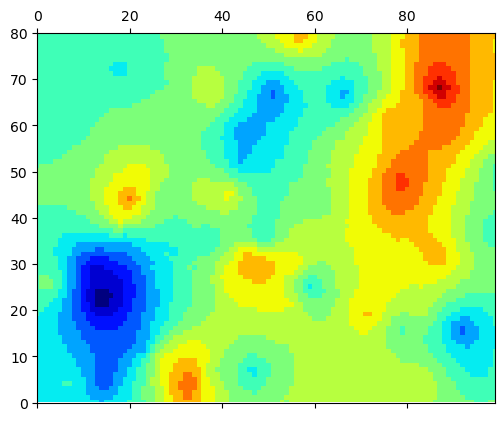

In [18]:
fig, ax = subplots()
H = np.zeros_like( Z )
for i in range( Z.shape[0] ):
    for j in range( Z.shape[1] ):
        H[i,j] = np.round( Z[i,j]*3 )
 
ax.matshow( H,  interpolation='nearest',cmap='jet' )
ax.scatter( z.x/200.0, z.y/200.0, facecolor='none', linewidths=0.75, s=50 )
xlim(0,99) ; ylim(0,80)

## Validation Croisée

In [19]:
def DATA():
    z = open( 'ZoneA.dat','r' ).readlines()
    z = [ i.strip().split() for i in z[10:] ]
    z = np.array( z, dtype=np.float )
    z = DataFrame( z, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )
    return z
z=DATA()
P = np.array( z[['x','y','por']] )

C:\Users\vince\AppData\Local\Temp\ipykernel_4716\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )


In [20]:
def Val():
    mse=[]
    Znew=[]
    theorie=[]
    l=[]
    z=DATA()
    for i in range(10):
        l.append(npr.randint(0,85))
    rows = z.loc[l]
    z.drop(l, axis=0, inplace=True)
    P = np.array( z[['x','y','por']] ) 
    for i in range(len(rows)):
        Znew.append(krige( P, exponential, hs, bw, (rows.iloc[i][0],rows.iloc[i][1]), 5 ))
        theorie.append(rows.iloc[i][3])
    MSE=mean_squared_error(Znew, theorie)
    return MSE

In [21]:
def boxplot():
    l=[]
    for i in range(10):
        l.append(Val())
    plt.boxplot(l)
    return l

C:\Users\vince\AppData\Local\Temp\ipykernel_4716\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_4716\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_4716\4

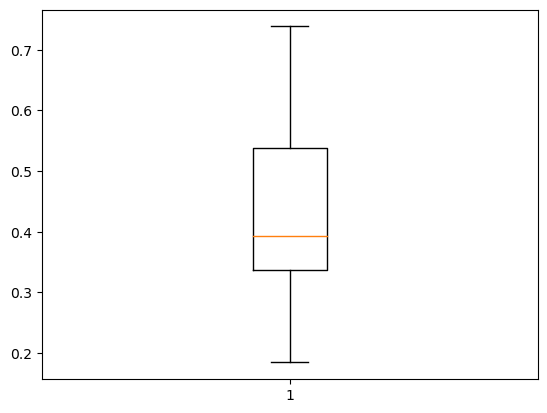

In [22]:
analy=boxplot()

## Interpolation de fonction du semi-variogram

In [23]:
f1 = interp1d(sv[0], sv[1],kind = 'linear')
f2 = interp1d(sv[0], sv[1], kind = 'cubic')

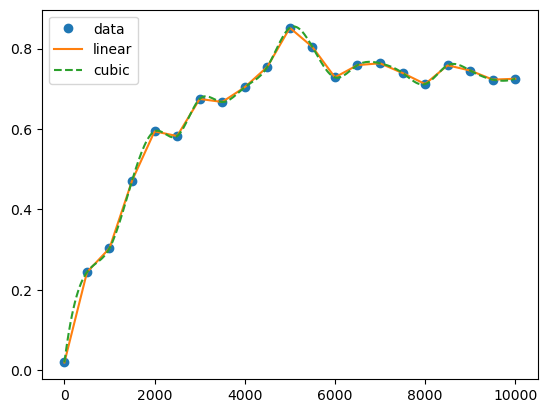

In [24]:
xnew = np.linspace(0, 10000,300)
plt.plot(sv[0], sv[1], 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic','nearest'], loc = 'best')
plt.show()

In [25]:
from scipy.interpolate import UnivariateSpline

In [26]:
spl = UnivariateSpline(sv[0], sv[1])

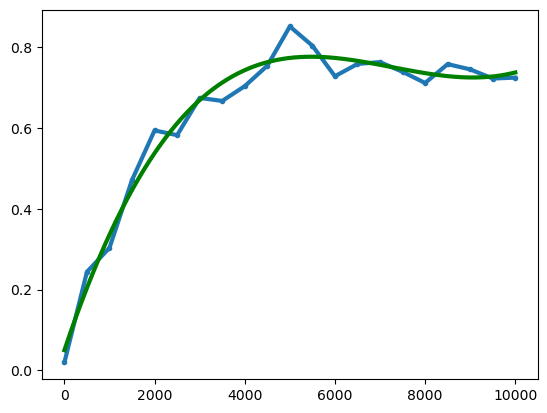

In [27]:
xs = np.linspace(0, 10000, 1000)
spl.set_smoothing_factor(0.1)
plt.plot(sv[0], sv[1], '.-' , xs, spl(xs), 'g', lw = 3)
plt.show()

## Test krigeage avec semi-variogram interpoler

In [28]:
def krige2( P, model, hs, bw, u, N ):
 
    mu = np.mean( P[:,2] ) ## moyenne des valeurs de toutes les données
 
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 ) ## matrice des distances entre le new et les points connus
    P = np.vstack(( P.T, d )).T ##ajout colonne distance
    P = P[d.argsort()[:N]]  ## garde les N premiers points proche de new
    
    k = model( P[:,3] ) 
    k = np.matrix( k ).T ## matrice des covariances entre le new et les N points

    K = squareform( pdist( P[:,:2] ) )
    K = model( K.ravel() )
    K = np.array( K )
    K = K.reshape(N,N)
    K = np.matrix( K ) ### matrice covariances entre les N points
    
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights ) ## calcul des poids
 
    residuals = P[:,2] - mu ## calcul des résidus
     
    estimation = np.dot( weights.T, residuals ) + mu ##estimations de la valeurs à l'emplacement new
    
    kvar = k.T * weights  
    var = np.var( P[:,2] )
    kvar = float( var  - kvar )
    kstd = kvar
    return float( estimation ),kstd

In [29]:
X0, X1 = P[:,0].min(), P[:,0].max()
Y0, Y1 = P[:,1].min(), P[:,1].max()
Z = np.zeros((80,100))
V= np.zeros((80,100))
dx, dy = (X1-X0)/100.0, (Y1-Y0)/80.0
for i in range( 80 ):
    for j in range( 100 ):
        Z[i,j],V[i,j] = krige2( P, spl, hs, bw, (dy*j,dx*i), 16 )   

(0.0, 80.0)

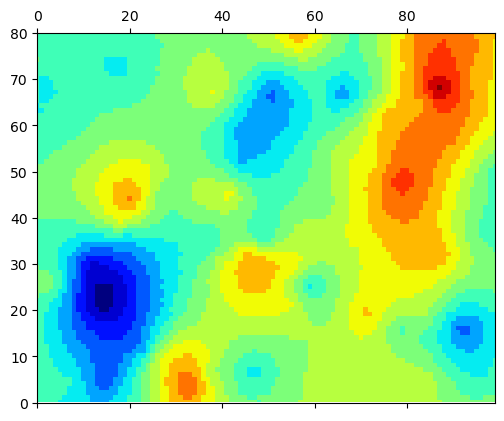

In [30]:
fig, ax = subplots()
H = np.zeros_like( Z )
for i in range( Z.shape[0] ):
    for j in range( Z.shape[1] ):
        H[i,j] = np.round( Z[i,j]*3 )
 
ax.matshow( H,cmap='jet')
ax.scatter( z.x/200.0, z.y/200.0, facecolor='none', linewidths=0.75, s=50 )
xlim(0,99) ; ylim(0,80)

## Graph erreur de prédiction ( à retravailler )

(0.0, 80.0)

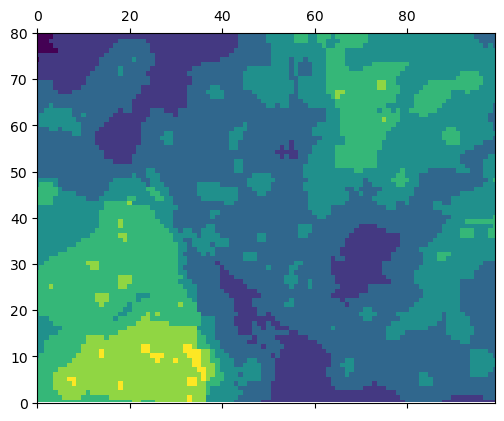

In [36]:
fig, ax = subplots()
H = np.zeros_like( Z )
for i in range( V.shape[0] ):
    for j in range( V.shape[1] ):
        H[i,j] = np.round( V[i,j]*3 )
 
ax.matshow( H )
ax.scatter( z.x/200.0, z.y/200.0,  facecolor='none',linewidths=0.75, s=50)
xlim(0,99) ; ylim(0,80)

## Validation croisée avec interpolation 

In [25]:
def Val2():
    mse=[]
    Znew=[]
    theorie=[]
    l=[]
    z=DATA()
    for i in range(10):
        l.append(npr.randint(0,85))    
    rows = z.loc[l]
    z.drop(l, axis=0, inplace=True)
    P = np.array( z[['x','y','por']] ) 
    for i in range(len(rows)):
        Znew.append(krige2( P, spl, hs, bw, (rows.iloc[i][0],rows.iloc[i][1]), 5 ))
        theorie.append(rows.iloc[i][3])
    MSE=mean_squared_error(Znew, theorie)
    return MSE

In [26]:
def boxplot2():
    l=[]
    for i in range(10):
        l.append(Val2())
    plt.boxplot(l)
    return l

C:\Users\vince\AppData\Local\Temp\ipykernel_8560\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_8560\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_8560\4

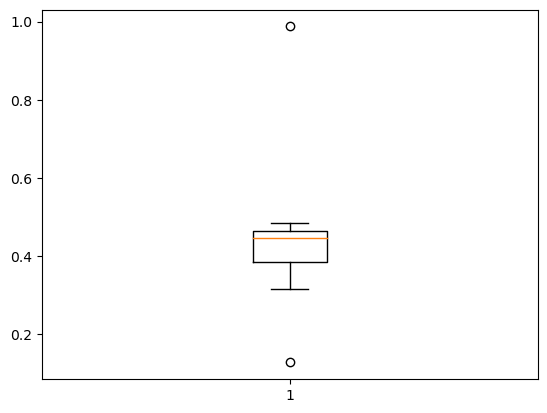

In [29]:
analy2=boxplot2()

## Mapping des erreurs ( à compléter)

C:\Users\vince\AppData\Local\Temp\ipykernel_8560\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_8560\489800339.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.array( z, dtype=np.float )
C:\Users\vince\AppData\Local\Temp\ipykernel_8560\4

<IPython.core.display.Javascript object>


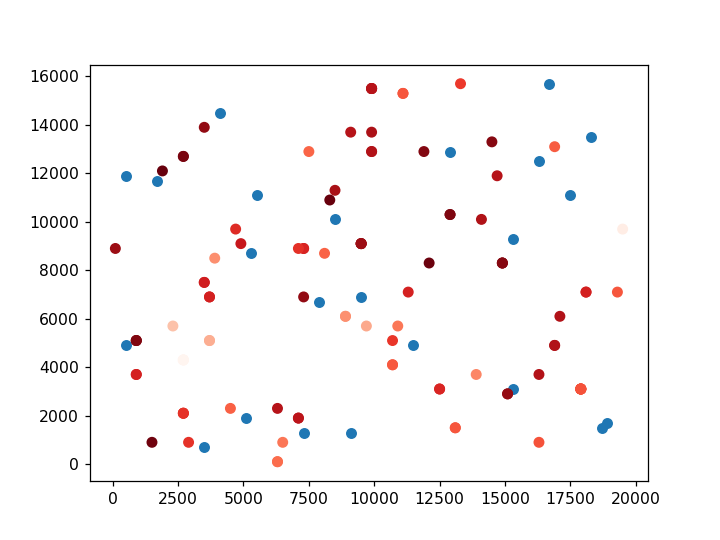

In [172]:
dico_erreur={}
for i in range(85):
    dico_erreur[f'{i}']=[]
for j in range(10):
    Znew=[]
    theorie=[]
    l=[]
    z=DATA()
    l=[npr.randint(0,85) for i in range(100)]   
    rows = z.loc[l]
    z.drop(l, axis=0, inplace=True)
    P = np.array( z[['x','y','por']] ) 
    for i in range(len(rows)):
        Znew.append(krige2( P, spl, hs, bw, (rows.iloc[i][0],rows.iloc[i][1]), 5 ))
        theorie.append(rows.iloc[i][3])
        dico_erreur[f'{rows.index[i]}'].append(np.abs(Znew[i]-theorie[i]))
erreur=[np.abs(Znew[i]-theorie[i]) for i in range(len(Znew))]

fig, ax = subplots()
ax.scatter( z.x, z.y )
ax.scatter(rows.x,rows.y,c=erreur,cmap='Reds_r')

In [176]:
for i in range(len(dico_erreur)):
    dico_erreur[f'{i}']=np.mean(dico_erreur[f'{i}'])

In [177]:
dico_erreur

{'0': 0.4586787775508386,
 '1': 0.38312366410749943,
 '2': 0.4182155100257836,
 '3': 1.3087911540411257,
 '4': 0.5317642149377082,
 '5': 0.6596759937882808,
 '6': 0.39651074763060057,
 '7': 0.35846830086953163,
 '8': 0.4122792231853805,
 '9': 0.3706567020674691,
 '10': 0.19003435588361717,
 '11': 1.0681206935655814,
 '12': 0.22565956420588335,
 '13': 0.3138944564173341,
 '14': 0.21920510757189185,
 '15': 0.4544380875322107,
 '16': 0.6172885801224137,
 '17': 1.30540477918257,
 '18': 1.3472858452785785,
 '19': 0.35321310729657274,
 '20': 0.3032513454249586,
 '21': 0.9427701520727721,
 '22': 0.4029528445485494,
 '23': 0.7581810847134044,
 '24': 1.1381203753972258,
 '25': 0.5100160473732349,
 '26': 0.5328137562794659,
 '27': 0.6110664769092994,
 '28': 0.8769495733037538,
 '29': 1.3274746471370946,
 '30': 0.6809164614849997,
 '31': 0.29122792609303766,
 '32': 0.955096488416154,
 '33': 0.8872752422675287,
 '34': 0.2762930408778501,
 '35': 0.8308710859676001,
 '36': 0.5525140563765354,
 '37':

In [184]:
for i in range(85):
    P[i][2]=dico_erreur[f'{i}']

In [186]:
X0, X1 = P[:,0].min(), P[:,0].max()
Y0, Y1 = P[:,1].min(), P[:,1].max()
Z = np.zeros((80,100))
dx, dy = (X1-X0)/100.0, (Y1-Y0)/80.0
for i in range( 80 ):
    for j in range( 100 ):
        Z[i,j] = krige2( P, spl, hs, bw, (dy*j,dx*i), 16 ) 

In [202]:
print(Z[32][4])
print(Z[13][62])

0.8020619611658086
0.4374048271150638


<IPython.core.display.Javascript object>


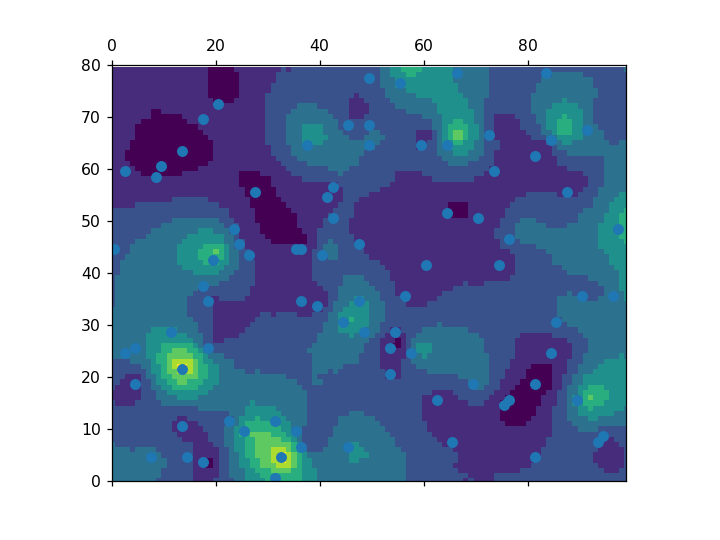

(0.0, 80.0)

In [200]:
fig, ax = subplots()
H = np.zeros_like( Z )
for i in range( Z.shape[0] ):
    for j in range( Z.shape[1] ):
        H[i,j] = np.round( Z[i,j]*5)
 
ax.matshow( H,  interpolation='nearest' )
ax.scatter( z.x/200.0, z.y/200.0)
xlim(0,99) ; ylim(0,80)

## Plot 3D

<IPython.core.display.Javascript object>


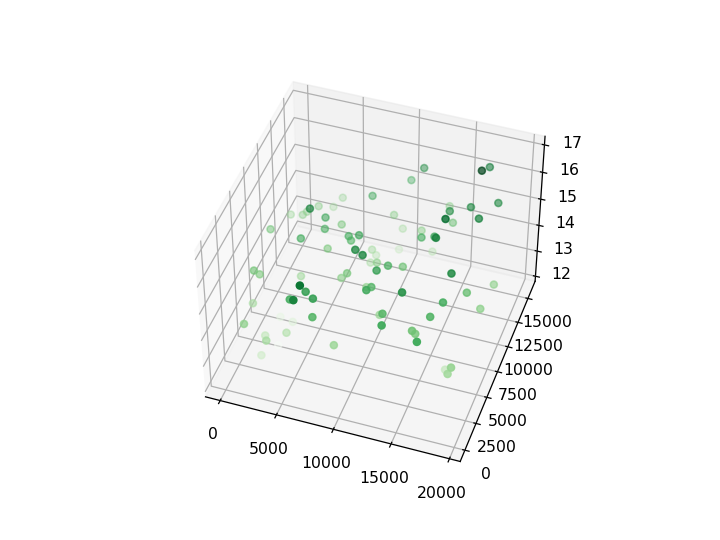

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
### rajout couleur 
ax.scatter3D(z.x, z.y, z.por, c=z.por, cmap='Greens');

<IPython.core.display.Javascript object>


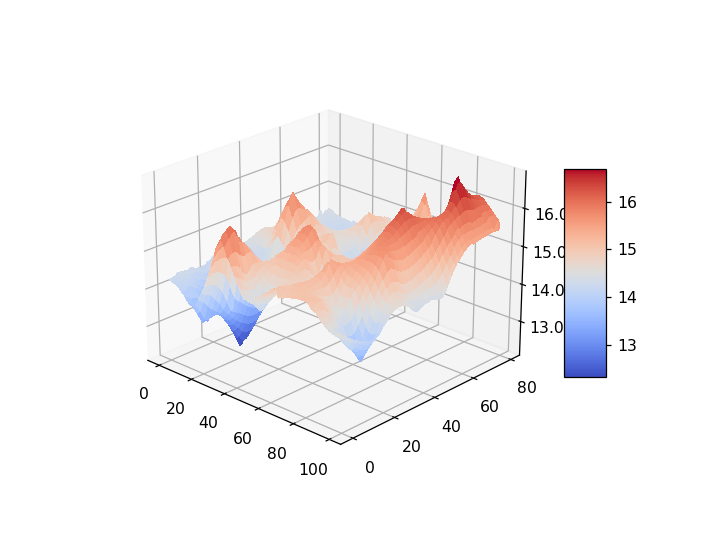

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.arange(0, 100, 1)
Y = np.arange(0, 80, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()